# Digitalis v3 Data


In [2]:
import sys

sys.path.insert(0, "../../src")
from imports import *

init_notebook()

## Load Coordinates


In [2]:
# Load EPSG:2154 Coordinates
coords = get_final_nfi_coordinates(
    epsg="2154", geojson_or_csv="csv", noisy_or_corrected="noisy"
)
display(coords)

Loading noisy coordinates from csv.


,SiteID,idp,first_year,y,x,y_fr,x_fr
0,0,500008,2010,48.050169,6.069033,6776642.0,928613.0
1,1,500013,2010,49.200152,1.132653,6901657.0,563902.0
2,2,500098,2010,44.180055,4.700859,6343803.0,835978.0
3,3,500103,2010,48.966655,7.119338,6881944.0,1001476.0
4,4,500137,2010,48.370070,6.713368,6814217.0,974906.0
...,...,...,...,...,...,...,...
51408,51408,1354883,2018,43.285850,-1.426182,6253036.0,340732.0
51409,51409,1354893,2018,45.886689,-0.547316,6538069.0,424990.0
51410,51410,1354907,2018,44.826139,2.288525,6414362.0,643763.0
51411,51411,1354911,2018,48.225672,4.438676,6792676.0,806833.0


## List of available variables

(1961 to 2020) x (12 Months + 5 Temporal Aggregates + Historical Climate + Contemporaty Climate)

= 60years x 17 vars

= 1044 max variables per dataset

**Available Vars:**

- bhc
- deth
- etp
- prec
- radneb
- ruth
- tmax
- tmin
- tmoy


## Python Extraction


### Check if all files are present


In [3]:
# Check if all files per year are present

for dataset in [
    "tmoy",
    "tmin",
    "tmax",
    "ruth",
    # "deth",
    # "radneb",
    # "etp",
    # "bhc",
    # "prec",
]:

    files = glob.glob(f"../../data/raw/digitalis_v3/1km/{dataset}/*.tif")
    files = pd.DataFrame(files, columns=["files"])
    files["year"] = files["files"].apply(lambda x: int(x.split("_")[-2].split("_")[0]))

    # Count files per year
    print("\n")
    print("-------------------")
    print(f"⭐ {dataset}")
    print(
        f" - Total number of years: {files.year.value_counts().sort_index().__len__()}\n - Total number of files: {files.year.value_counts().sort_index().sum()}"
    )
    # Print groups with less than 17 files
    print(" - Dataset-Years with less than 17 files:\n")
    print(
        files.groupby("year").count()["files"][
            files.groupby("year").count()["files"] != 17
        ]
    )



-------------------
⭐ tmoy
 - Total number of years: 0
 - Total number of files: 0
 - Dataset-Years with less than 17 files:

Series([], Name: files, dtype: int64)


-------------------
⭐ tmin
 - Total number of years: 0
 - Total number of files: 0
 - Dataset-Years with less than 17 files:

Series([], Name: files, dtype: int64)


-------------------
⭐ tmax
 - Total number of years: 0
 - Total number of files: 0
 - Dataset-Years with less than 17 files:

Series([], Name: files, dtype: int64)


-------------------
⭐ ruth
 - Total number of years: 0
 - Total number of files: 0
 - Dataset-Years with less than 17 files:

Series([], Name: files, dtype: int64)


### Run zonal mean extraction


> 🚨: If running all sites, it takes VERY long! Smaller coord dfs to sample are faster, so I could split it by year or so. But this requires more code to merge all sites together in the end.


In [4]:
# Define data range
data_range = "only_2023"  # all - until_2022 = only_2023

# Get buffered coordinates
buffer = gpd.read_file("../../data/final/nfi/700m_buffer_epsg2154.geojson")

# Filter first_year depending on data_range
if data_range == "until_2022":
    buffer = buffer[buffer["first_year"] < 2018]
elif data_range == "only_2023":
    buffer = buffer[buffer["first_year"] == 2018]
elif data_range == "all":
    data_range = "all/direct"
else:
    raise ValueError("data_range not recognized")

# Get files
files = glob.glob("/Volumes/SAMSUNG 1TB/digitalis_v3/raw/1km/*/*.tif")

# ! Debug: I AM ONLY EXTRACTING MONTHLY VALUES, NO AGGREGATED VALUES
# Aggregated values are: 6190, 9120, 6120, hi, pr, et, aut, 13 (or ann?)
files = [
    f
    for f in files
    if "_1.tif" in f
    or "_2.tif" in f
    or "_3.tif" in f
    or "_4.tif" in f
    or "_5.tif" in f
    or "_6.tif" in f
    or "_7.tif" in f
    or "_8.tif" in f
    or "_9.tif" in f
    or "_10.tif" in f
    or "_11.tif" in f
    or "_12.tif" in f
]

# Remove annual aggregated files
files = [f for f in files if "6190" not in f]
files = [f for f in files if "9120" not in f]
files = [f for f in files if "6120" not in f]

# ! Debug: Remove bhc, deth, ruth, radneb for now
files = [f for f in files if "bhc" not in f]
files = [f for f in files if "deth" not in f]
files = [f for f in files if "ruth" not in f]
files = [f for f in files if "radneb" not in f]

# Turn into dataframe
df_files = pd.DataFrame(files, columns=["path"])
df_files["filename"] = df_files["path"].apply(lambda x: x.split("/")[-1].split(".")[0])
df_files["year"] = df_files["filename"].apply(lambda x: int(x.split("_")[1]))
df_files["dataset"] = df_files["filename"].apply(lambda x: x.split("_")[0])
df_files = df_files.sort_values("filename")

# Display files
display(df_files.dataset.value_counts())
display(df_files.head())
list_files = split_df_into_list_of_group_or_ns(df_files, 10)

run_mp(
    extract_zonal_mean,
    list_files,
    buffer=buffer,
    num_cores=10,
    force_run=True,
    save_dir=f"/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/{data_range}/zonal_mean",
)

dataset
prec    720
tmax    720
tmin    720
tmoy    720
etp     719
Name: count, dtype: int64

,path,filename,year,dataset
1757,/Volumes/SAMSUNG 1TB/digitalis_v3/raw/1km/etp/...,etp_1961_1,1961,etp
1772,/Volumes/SAMSUNG 1TB/digitalis_v3/raw/1km/etp/...,etp_1961_10,1961,etp
1774,/Volumes/SAMSUNG 1TB/digitalis_v3/raw/1km/etp/...,etp_1961_11,1961,etp
1729,/Volumes/SAMSUNG 1TB/digitalis_v3/raw/1km/etp/...,etp_1961_12,1961,etp
1713,/Volumes/SAMSUNG 1TB/digitalis_v3/raw/1km/etp/...,etp_1961_2,1961,etp


/Users/pascal/repos/padasch/ifn_analysis/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


 - Splitting df into 10 random groups


100%|██████████| 10/10 [1:05:20<00:00, 392.10s/it]


[None, None, None, None, None, None, None, None, None, None]

## Turn raster extraction into long format


In [14]:
for dataset in [
    # "tmoy",
    # "tmin",
    # "tmax",
    # "prec",
    "etp",
    # "bhc",
    # "ruth",
    # "deth",
    # "radneb",
]:

    # Load all files
    files = glob.glob(
        f"/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/{data_range}/zonal_mean/*.feather"
    )

    # Filter for dataset
    files = [f for f in files if dataset in f]

    if len(files) != 720:
        print(
            f" 🚨 The number of files for '{dataset}' \tis not 720 (60 years * 12 months) but: {len(files)}"
        )
        if len(files) == 0:
            continue
    else:
        print(
            f" ✅ The number of files for '{dataset}' \tis 720 (60 years * 12 months)"
        )

    # Loop through all files and attach to them by idp and first year
    all_files = []
    for file in files:
        # Load file
        df = pd.read_feather(file)
        # Get filename
        filename = df.columns[-1]
        # Extract dataset and month
        dataset = filename.split("_")[0]
        df["month"] = filename.split("_")[-1]
        df["year"] = filename.split("_")[-2]
        # Rename column to value
        df = df.rename(columns={filename: "value"})
        # Attach to list
        all_files.append(df.reset_index(drop=True))

    # Concatenate all files by row
    df_all = (
        pd.concat(all_files, axis=0)
        .sort_values(["year", "month", "idp"])
        .reset_index(drop=True)
    )
    df_all

    # Save to feather
    df_all.to_feather(
        f"/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/{data_range}/zonal_mean_long/{dataset}.feather"
    )

NameError: name 'data_range' is not defined

## Merge 2023 data into existing one


In [18]:
for dataset in [
    "tmoy",
    "tmin",
    "tmax",
    "prec",
    "etp",
    # "bhc",
    # "ruth",
    # "deth",
    # "radneb",
]:

    # Verbose
    display(f" --- Dataset: {dataset} ---")

    # Set filename
    old_file = f"/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/until_2022/zonal_mean_long_{dataset}.feather"
    new_files = f"/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/only_2023/zonal_mean_long/{dataset}.feather"

    # Check if files exists
    if not os.path.exists(old_file):
        print(f" 🚨 File '{old_file}' does not exist")
        continue
    else:
        print(f" ✅ File '{old_file}' exists")

    if not os.path.exists(new_files):
        print(f" 🚨 File '{new_files}' does not exist")
        continue
    else:
        print(f" ✅ File '{new_files}' exists")

    # Load data
    old_data = pd.read_feather(old_file)
    new_data = pd.read_feather(new_files)

    # Make sure none of these aggregations are present
    old_data = old_data.query("year not in ['13', '6190', '9120', '6120']")
    new_data = new_data.query("year not in ['13', '6190', '9120', '6120']")

    # Combine data
    df_all = pd.concat([old_data, new_data], axis=0).reset_index(drop=True)

    # ! Quality Checks
    save_to_dump = False
    # Print shape
    print(f" - Shape of old data: {old_data.shape}")
    print(f" - Shape of new data: {new_data.shape}")
    print(f" - Shape of combined data: {df_all.shape}")

    # Print sites
    old_sites = old_data["idp"].nunique()
    new_sites = new_data["idp"].nunique()
    combined_sites = df_all["idp"].nunique()
    print(f" - Number of sites in old data: {old_sites}")
    print(f" - Number of sites in new data: {new_sites}")
    print(f" - Number of sites in combined data: {combined_sites}")

    # To ensure that all year-months and no aggregates are present
    # we will check the number of unique year-month combinations
    actual_combinations = df_all[["year", "month"]].drop_duplicates().shape[0]

    if dataset == "etp":
        expected_combinations = 719  # ETP is missing one month of data
    elif dataset == "radneb":
        expected_combinations = 717  # Radneb is missing 3 months of data
    else:
        expected_combinations = 720  # 60*12 = 720

    if actual_combinations != expected_combinations:
        save_to_dump = True
        print(
            f" 🚨 Expected year-month combinations = {expected_combinations} but actual combinations = {actual_combinations}. Saving data to dump folder"
        )

    else:
        print(
            f" ✅ Expected and actual year-month combinations are the same: {actual_combinations} = {expected_combinations}"
        )

    # To ensure all data is present, we calculate the expectd number of idp-year-month combinations. The df should have that many entries
    expected = df_all.idp.nunique() * df_all.year.nunique() * df_all.month.nunique()
    actual = df_all.shape[0]

    if actual != expected:
        save_to_dump = True
        print(
            f" 🚨 Expected number of entries = {expected} but actual number of entries = {actual}. Saving data to dump folder"
        )

    if save_to_dump:
        final_file = f"/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/all/merged/dump/{dataset}.feather"

    else:
        final_file = f"/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/all/merged/{dataset}.feather"

    # Save to feather
    df_all.to_feather(final_file)

    # Verbose
    print(f" 💾 Saved to: {final_file}")

' --- Dataset: tmoy ---'

 ✅ File '/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/until_2022/zonal_mean_long_tmoy.feather' exists
 ✅ File '/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/only_2023/zonal_mean_long/tmoy.feather' exists
 - Shape of old data: (33343920, 5)
 - Shape of new data: (3673440, 5)
 - Shape of combined data: (37017360, 5)
 - Number of sites in old data: 46311
 - Number of sites in new data: 5102
 - Number of sites in combined data: 51413
 ✅ Expected and actual year-month combinations are the same: 720 = 720
 💾 Saved to: /Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/all/merged/tmoy.feather


' --- Dataset: tmin ---'

 ✅ File '/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/until_2022/zonal_mean_long_tmin.feather' exists
 ✅ File '/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/only_2023/zonal_mean_long/tmin.feather' exists
 - Shape of old data: (33343920, 5)
 - Shape of new data: (3673440, 5)
 - Shape of combined data: (37017360, 5)
 - Number of sites in old data: 46311
 - Number of sites in new data: 5102
 - Number of sites in combined data: 51413
 ✅ Expected and actual year-month combinations are the same: 720 = 720
 💾 Saved to: /Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/all/merged/tmin.feather


' --- Dataset: tmax ---'

 ✅ File '/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/until_2022/zonal_mean_long_tmax.feather' exists
 ✅ File '/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/only_2023/zonal_mean_long/tmax.feather' exists
 - Shape of old data: (33343920, 5)
 - Shape of new data: (3673440, 5)
 - Shape of combined data: (37017360, 5)
 - Number of sites in old data: 46311
 - Number of sites in new data: 5102
 - Number of sites in combined data: 51413
 ✅ Expected and actual year-month combinations are the same: 720 = 720
 💾 Saved to: /Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/all/merged/tmax.feather


' --- Dataset: prec ---'

 ✅ File '/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/until_2022/zonal_mean_long_prec.feather' exists
 ✅ File '/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/only_2023/zonal_mean_long/prec.feather' exists
 - Shape of old data: (33343920, 5)
 - Shape of new data: (3673440, 5)
 - Shape of combined data: (37017360, 5)
 - Number of sites in old data: 46311
 - Number of sites in new data: 5102
 - Number of sites in combined data: 51413
 ✅ Expected and actual year-month combinations are the same: 720 = 720
 💾 Saved to: /Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/all/merged/prec.feather


' --- Dataset: etp ---'

 ✅ File '/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/until_2022/zonal_mean_long_etp.feather' exists
 ✅ File '/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/only_2023/zonal_mean_long/etp.feather' exists
 - Shape of old data: (33297609, 5)
 - Shape of new data: (3668338, 5)
 - Shape of combined data: (36965947, 5)
 - Number of sites in old data: 46311
 - Number of sites in new data: 5102
 - Number of sites in combined data: 51413
 ✅ Expected and actual year-month combinations are the same: 719 = 719
 🚨 Expected number of entries = 37017360 but actual number of entries = 36965947. Saving data to dump folder
 💾 Saved to: /Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/all/merged/dump/etp.feather


In [7]:
chime.success("All done!")
print(
    "Reminder: Next, do some quality checks on the data and then calcualte the derivatives!"
)

Reminder: Next, do some quality checks on the data and then calcualte the derivatives!


## Make Final Derivatives


In [3]:
# 🚨 Set source, whether merged or directly extracted data
source = "merged"  # merged or direct

# Fix source path
source = f"all/{source}"

## Quality control


In [1]:
for dataset in [
    "tmoy",
    "tmin",
    "tmax",
    "prec",
    "etp",
    "bhc",
    "ruth",
    "deth",
    "radneb",
]:

    df = f"/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/{source}/{dataset}.feather"
    if not os.path.exists(df):
        print(f" 🚨 File for {dataset} is missing")
    else:
        df = pd.read_feather(df)
        print(
            f"The shape of {dataset} is {df.shape} and the value column has {df['value'].isna().sum() / df.shape[0]:.2f}% missing values."
        )

NameError: name 'source' is not defined

### SPEI


In [21]:
# Load data
df_etp = (
    pd.read_feather(
        f"/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/{source}/etp.feather"
    )
    .rename(columns={"value": "etp"})
    .reset_index(drop=True)
)
df_prec = (
    pd.read_feather(
        f"/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/{source}/prec.feather"
    )
    .rename(columns={"value": "prec"})
    .reset_index(drop=True)
)

# Merge data
spei_data = pd.merge(
    df_etp, df_prec, on=["idp", "first_year", "year", "month"], how="outer"
)

# Clean dates
spei_data["date"] = spei_data["year"] + "-" + spei_data["month"]
spei_data["date"] = pd.to_datetime(spei_data["date"], format="%Y-%m")
spei_data = spei_data.drop(columns=["year", "month"])
spei_data = spei_data.sort_values(by=["idp", "date"])
spei_data = spei_data.reset_index(drop=True)

# Saving to csv because of issues to load feather files in R... takes ~40s
spei_data.to_csv(
    f"/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/{source}/data_to_calculate_spei.csv",
    index=False,
)

# Display
spei_data

,idp,first_year,etp,prec,date
0,500002,2010,45.0,770.0,1961-01-01
1,500002,2010,246.0,589.0,1961-02-01
2,500002,2010,467.0,169.0,1961-03-01
3,500002,2010,676.0,718.0,1961-04-01
4,500002,2010,879.0,755.0,1961-05-01
...,...,...,...,...,...
37017355,1354931,2018,1152.5,540.0,2020-08-01
37017356,1354931,2018,760.0,976.0,2020-09-01
37017357,1354931,2018,378.5,1318.5,2020-10-01
37017358,1354931,2018,288.5,406.5,2020-11-01


🚨 FINISH SPEI CALCULATION IN R


### Temperature and Precipitation Anomalies


In [19]:
for dataset in [
    "tmoy",
    "tmin",
    "tmax",
    # "prec",
    # "etp",
]:
    print(f"\n--- Working on {dataset} ---")
    df = get_anomaly_metrics_loop_mp(
        dataset, years_before_second_visit=7, source=source
    )
    df.to_feather(
        f"/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/{source}/anomalies/digitalis_{dataset}.feather"
    )


--- Working on tmoy ---
Loading data from /Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/all/merged/tmoy.feather...
Cleaning data...
 - Splitting df into 10 groups, grouped by idp
Extracting anomalies...


100%|██████████| 10/10 [03:56<00:00, 23.62s/it]



--- Working on tmin ---
Loading data from /Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/all/merged/tmin.feather...
Cleaning data...
 - Splitting df into 10 groups, grouped by idp
Extracting anomalies...


100%|██████████| 10/10 [03:38<00:00, 21.90s/it]



--- Working on tmax ---
Loading data from /Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/all/merged/tmax.feather...
Cleaning data...
 - Splitting df into 10 groups, grouped by idp
Extracting anomalies...


100%|██████████| 10/10 [03:31<00:00, 21.17s/it]



--- Working on prec ---
Loading data from /Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/all/merged/prec.feather...
Cleaning data...
 - Splitting df into 10 groups, grouped by idp
Extracting anomalies...


100%|██████████| 10/10 [04:19<00:00, 25.95s/it]


ValueError: zero-size array to reduction operation maximum which has no identity

---


# Extraction Examples


## Temp. Anomaly Extraction Example


In [1]:
import sys

sys.path.insert(0, "../../src")
from imports import *

init_notebook()

In [6]:
# Input
dataset = "tmoy"  # tmoy or spei
source = "all/merged"  # Pick source
iseed = 1  # Set seed
myseason = "JJA"  # Set season

In [7]:
# Load data
file = f"/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/{source}/{dataset}.feather"
ex = pd.read_feather(file)

# Pick example site
unique_sites = ex["idp"].unique()
example_site = pd.Series(unique_sites).sample(1, random_state=iseed).values[0]

# ! Filter for example site
# ex = ex.query(f"idp == {example_site}").copy()

# ! Take the mean across all sites
ex = ex.groupby(["year", "month"]).mean().reset_index()

# Clean data
ex["value"] = ex["value"] / 10
ex = ex[pd.to_numeric(ex["month"], errors="coerce").notna()]
ex = (
    ex.query("month not in ['au', 'et', 'hi', 'pr', '13']")
    .assign(
        year=lambda x: pd.to_numeric(x["year"]),
        month=lambda x: pd.to_numeric(x["month"]).apply(lambda m: str(m).zfill(2)),
        date=lambda x: x["year"].astype(str) + "-" + x["month"].astype(str) + "-01",
        month_count=lambda x: ex["month"].astype(int)
        * (ex.year.astype(int) - 1960)
        / 12,
    )
    .assign(date=lambda x: pd.to_datetime(x["date"], errors="coerce"))
    .dropna()
    .loc[lambda x: x["year"].between(1961, 2020)]
)
ex["date"] = pd.to_datetime(ex["date"])
ex["month"] = ex["month"].astype(int)

ex = ex.sort_values(by=["date"])

# Change month to season string
ex["month"] = ex["month"].map(
    {
        1: "DJF",
        2: "DJF",
        3: "MAM",
        4: "MAM",
        5: "MAM",
        6: "JJA",
        7: "JJA",
        8: "JJA",
        9: "SON",
        10: "SON",
        11: "SON",
        12: "DJF",
    }
)

# Get data for season
ex_season = ex.query(f"month == '{myseason}'")

# Calculate anomalies
ex_season_anom = ex_season.copy()
ex_season_anom["value"] = ex_season_anom["value"] - ex_season_anom["value"].mean()

# Get data for season zoomed in
ex_season_anom_zoomed = ex_season_anom.query(
    "date >= '2000-01-01' & date <= '2007-12-31'"
).copy()
ex_zoomed = ex.query("date >= '2000-01-01' & date <= '2007-12-31'").copy()

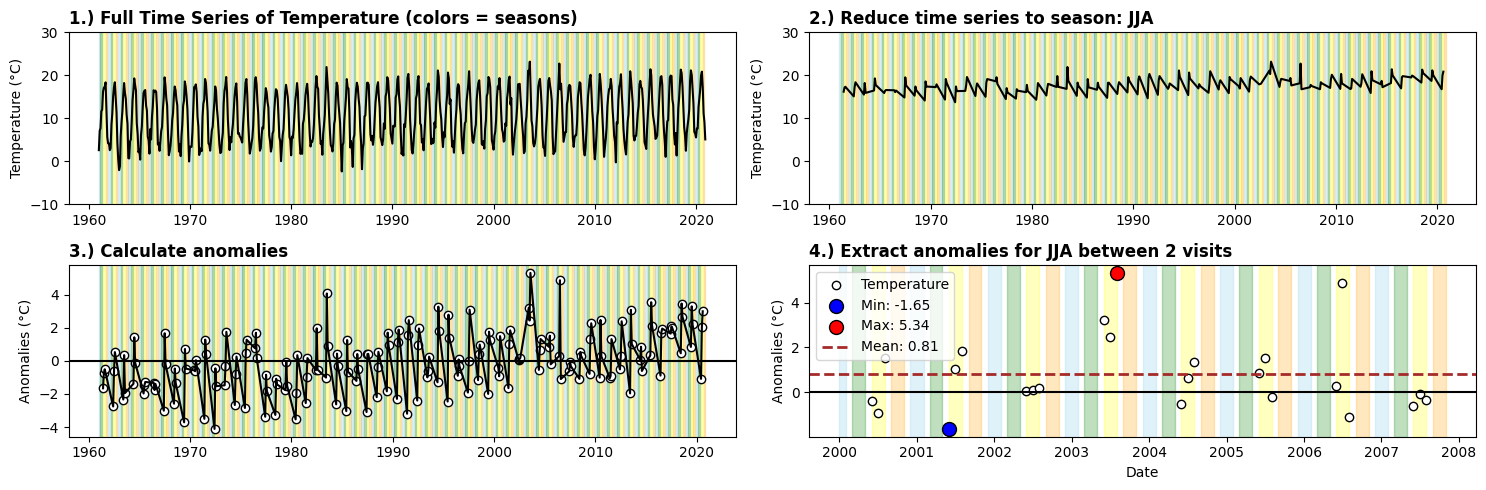

In [ ]:
# Set season colors
season_colors = {
    "DJF": "skyblue",
    "MAM": "green",
    "JJA": "yellow",
    "SON": "orange",
}

# fig, ax = plt.subplots(4, 1, figsize=(10, 10))
fig, ax = plt.subplots(2, 2, figsize=(15, 5))
ax = ax.flatten()

# 1. Temperature Time Series
# Add background for seasons
current_season = ex["month"].iloc[0]
start_date = ex["date"].iloc[0]

for i in range(1, len(ex)):
    if ex["month"].iloc[i] != current_season:
        # End of the current season
        end_date = ex["date"].iloc[i - 1]
        ax[0].axvspan(
            start_date, end_date, color=season_colors[current_season], alpha=0.25
        )
        # Start a new season span
        current_season = ex["month"].iloc[i]
        start_date = ex["date"].iloc[i]

ax[0].plot(
    ex["date"],
    ex["value"],
    label="Precipitation",
    color="black",
)
ax[0].set_ylabel("Temperature (°C)")
ax[0].tick_params(axis="y")
ax[0].set_title(
    f"1.) Full Time Series of Temperature (colors = seasons)",
    fontweight="bold",
    loc="left",
)
ax[0].set_ylim(-10, 30)

# 2. Temperature Time Series of Season
# Add background for seasons
# Set all except chosen season to white
# for season in ["DJF", "MAM", "JJA", "SON"]:
#     if season != myseason:
#         season_colors[season] = "white"

current_season = ex["month"].iloc[0]
start_date = ex["date"].iloc[0]

for i in range(1, len(ex)):
    if ex["month"].iloc[i] != current_season:
        # End of the current season
        end_date = ex["date"].iloc[i - 1]
        ax[1].axvspan(
            start_date, end_date, color=season_colors[current_season], alpha=0.25
        )
        # Start a new season span
        current_season = ex["month"].iloc[i]
        start_date = ex["date"].iloc[i]


ax[1].plot(
    ex_season["date"],
    ex_season[f"value"],
    color="black",
)
# ax[1].scatter(
#     ex_season["date"],
#     ex_season[f"value"],
#     color="white",
#     edgecolor="black",
#     label="Temperature",
# )
ax[1].set_title(
    f"2.) Reduce time series to season: {myseason}",
    fontweight="bold",
    loc="left",
)
ax[1].set_ylabel("Temperature (°C)")
ax[1].set_ylim(-10, 30)

# 3. Temperature Time Series of Season with Anomalies
# Add background for seasons
current_season = ex["month"].iloc[0]
start_date = ex["date"].iloc[0]

for i in range(1, len(ex)):
    if ex["month"].iloc[i] != current_season:
        # End of the current season
        end_date = ex["date"].iloc[i - 1]
        ax[2].axvspan(
            start_date, end_date, color=season_colors[current_season], alpha=0.25
        )
        # Start a new season span
        current_season = ex["month"].iloc[i]
        start_date = ex["date"].iloc[i]

ax[2].axhline(0, color="black", linestyle="-")

ax[2].plot(
    ex_season_anom["date"],
    ex_season_anom[f"value"],
    color="black",
)
ax[2].scatter(
    ex_season_anom["date"],
    ex_season_anom[f"value"],
    color="white",
    edgecolor="black",
    label="Temperature",
)
ax[2].set_title(f"3.) Calculate anomalies", fontweight="bold", loc="left")
ax[2].set_ylabel("Anomalies (°C)")

# 4. Temperature Time Series of Season Zoomed
# Add background for seasons
current_season = ex_zoomed["month"].iloc[0]
start_date = ex_zoomed["date"].iloc[0]

for i in range(1, len(ex_zoomed)):
    if ex_zoomed["month"].iloc[i] != current_season:
        # End of the current season
        end_date = ex_zoomed["date"].iloc[i - 1]
        ax[3].axvspan(
            start_date, end_date, color=season_colors[current_season], alpha=0.25
        )
        # Start a new season span
        current_season = ex_zoomed["month"].iloc[i]
        start_date = ex_zoomed["date"].iloc[i]

ax[3].axhline(0, color="black", linestyle="-")
ax[3].scatter(
    ex_season_anom_zoomed["date"],
    ex_season_anom_zoomed[f"value"],
    color="white",
    edgecolor="black",
    label="Temperature",
)

# Plot min, max, and mean
# Mark min, max and mean values
min_temp = ex_season_anom_zoomed["value"].min()
max_temp = ex_season_anom_zoomed["value"].max()
mean_temp = ex_season_anom_zoomed["value"].mean()

# Add points for min and max
ax[3].scatter(
    ex_season_anom_zoomed.loc[ex_season_anom_zoomed["value"] == min_temp, "date"],
    min_temp,
    color="blue",
    edgecolor="black",
    s=100,
    marker="o",
    label=f"Min: {min_temp:.2f}",
)

ax[3].scatter(
    ex_season_anom_zoomed.loc[ex_season_anom_zoomed["value"] == max_temp, "date"],
    max_temp,
    color="red",
    edgecolor="black",
    s=100,
    marker="o",
    label=f"Max: {max_temp:.2f}",
)

ax[3].axhline(
    mean_temp,
    color="brown",
    linestyle="--",
    label=f"Mean: {mean_temp:.2f}",
    linewidth=2,
)

ax[3].legend(loc="upper left")


ax[3].set_title(
    f"4.) Extract anomalies for {myseason} between 2 visits",
    fontweight="bold",
    loc="left",
)
ax[3].set_ylabel("Anomalies (°C)")

ax[3].set_xlabel("Date")

plt.tight_layout()
plt.savefig("../../notebooks/02_collect_features/example_temp_features.png")
plt.show()

## Temp. trend across all sites


In [1]:
import sys

sys.path.insert(0, "../../src")
from imports import *

init_notebook()

import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

In [5]:
source = "all/merged"  # Pick source

,year,month,idp,first_year,value,tvar,season,date,date_num
0,1961,1,905618.302161,2013.759399,2.551143,tmoy,DJF,1961-01-01,-3287.0
1,1961,10,905618.302161,2013.759399,11.691838,tmoy,SON,1961-10-01,-3014.0
2,1961,11,905618.302161,2013.759399,5.584475,tmoy,SON,1961-11-01,-2983.0
3,1961,12,905618.302161,2013.759399,4.129039,tmoy,DJF,1961-12-01,-2953.0
4,1961,2,905618.302161,2013.759399,7.069106,tmoy,DJF,1961-02-01,-3256.0
...,...,...,...,...,...,...,...,...,...
715,2020,5,905618.302161,2013.759399,8.975395,tmin,MAM,2020-05-01,18383.0
716,2020,6,905618.302161,2013.759399,11.466741,tmin,JJA,2020-06-01,18414.0
717,2020,7,905618.302161,2013.759399,13.563500,tmin,JJA,2020-07-01,18444.0
718,2020,8,905618.302161,2013.759399,14.737549,tmin,JJA,2020-08-01,18475.0


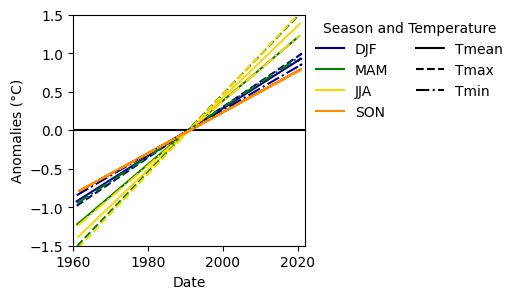

In [6]:
# Input
datasets = ["tmoy", "tmax", "tmin"]  # Pick dataset
seasons_to_plot = ["DJF", "MAM", "JJA", "SON"]
iseed = 1  # Set seed


# Load data
df_list = []

for dataset in datasets:
    # Get file
    file = f"/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/{source}/{dataset}.feather"
    # Load data
    idf = pd.read_feather(file)
    # Remove year 6120
    idf = idf.query("year != '6120'")
    # Fix temperature value
    idf["value"] = idf["value"] / 10
    # Take mean across all sites
    idf = idf.groupby(["year", "month"]).mean().reset_index()
    # Attach dataset info
    idf["tvar"] = dataset
    # Append to list
    df_list.append(idf)

# Concatenate
df = pd.concat(df_list)

# Attach month based on season
df["month"] = df["month"].astype(int)
df["season"] = df["month"].map(
    {
        1: "DJF",
        2: "DJF",
        3: "MAM",
        4: "MAM",
        5: "MAM",
        6: "JJA",
        7: "JJA",
        8: "JJA",
        9: "SON",
        10: "SON",
        11: "SON",
        12: "DJF",
    }
)

# Attach date
df["date"] = pd.to_datetime(
    df["year"].astype(str) + "-" + df["month"].astype(str) + "-01"
)
# Attach numeric date
df["date_num"] = mdates.date2num(df["date"])
display(df)

# Loop over every dataset and season, and calculate the anomalies trend for that season
df_lms = []
df_values = []

for tvar in datasets:
    for season in seasons_to_plot:
        # Filter for dataset and season
        idf = df.query(f"tvar == '{tvar}' & season == '{season}'").copy()
        # Calculate anomalies
        idf["value"] = idf["value"] - idf["value"].mean()
        # Regress anomalies on date_num
        lm = LinearRegression()
        lm.fit(idf[["date_num"]], idf["value"])
        df_lms.append(
            pd.DataFrame(
                {
                    "tvar": tvar,
                    "season": season,
                    "slope": lm.coef_[0],
                    "intercept": lm.intercept_,
                },
                index=[0],
            )
        )
        # Calculate the values for the regression line
        df_values.append(
            pd.DataFrame(
                {
                    "date_num": idf["date_num"],
                    "tvar": tvar,
                    "season": season,
                    "value": lm.predict(idf[["date_num"]]),
                }
            )
        )

df_lms = pd.concat(df_lms)
df_values = pd.concat(df_values)
df_values = df_values.replace({"tmoy": "Tmean", "tmax": "Tmax", "tmin": "Tmin"})
df_values


# Plot the regression lines, tvar is linetype, season is color shade
tvar_linetypes = {
    "Tmean": "-",
    "Tmax": "--",
    "Tmin": "-.",
}

season_colors = {
    "DJF": "darkblue",
    "MAM": "green",
    "JJA": "gold",
    "SON": "darkorange",
}

# Start plot
# fig, ax = plt.subplots(1, 1, figsize=(12, 3))
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

# Add zero line
ax.axhline(0, color="black", linestyle="-")

# Add lines
for tvar in df_values["tvar"].unique():
    for season in seasons_to_plot:
        idf = df_values.query(f"tvar == '{tvar}' & season == '{season}'")
        ax.plot(
            idf["date_num"],
            idf["value"],
            linestyle=tvar_linetypes[tvar],
            color=season_colors[season],
        )

# Set the title and legend
# ax.set_title(
#     "Trends for different temperature variables and seasons", fontweight="bold"
# )
ax.set_xlabel("Date")
ax.set_ylabel("Anomalies (°C)")

# Use equal ylim
ax.set_ylim(-1.5, 1.5)

# Set x-axis to date format
ax.set_xlim(-3500.0, 19000)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_major_locator(mdates.YearLocator())

# Show every 10th date to avoid overlapping
ax.set_xticks(ax.get_xticks()[::20])

# Create legend handles for tvar linetypes
tvar_handles = [
    mlines.Line2D([], [], color="black", linestyle=linetype, label=tvar)
    for tvar, linetype in tvar_linetypes.items()
]

# Create legend handles for season colors
season_handles = [
    mlines.Line2D([], [], color=color, linestyle="-", label=season)
    for season, color in season_colors.items()
]

# Combine both sets of handles
fig.legend(
    handles=season_handles + tvar_handles,  # Combine both sets of handles
    loc="upper right",  # Position at the center top
    bbox_to_anchor=(1.6, 0.9),  # Move the legend below the plot
    # loc="upper left",  # Position at the center top
    # bbox_to_anchor=(0.125, 0.9),  # with upper left and fig size 6,3
    ncol=2,  # Arrange all items in one row
    title="Season and Temperature",  # Title for the legend
    frameon=False,
)

# Show the plot (optional, as this is just for the legend)
# plt.tight_layout(rect=[0, 0, 0.4, 1])
plt.show()

## Precip. trends


,year,month,idp,first_year,value,tvar,season,date,date_num
0,1961,1,905618.302161,2013.759399,109.485637,prec,DJF,1961-01-01,-3287.0
1,1961,10,905618.302161,2013.759399,112.133618,prec,SON,1961-10-01,-3014.0
2,1961,11,905618.302161,2013.759399,101.899022,prec,SON,1961-11-01,-2983.0
3,1961,12,905618.302161,2013.759399,98.078610,prec,DJF,1961-12-01,-2953.0
4,1961,2,905618.302161,2013.759399,59.861526,prec,DJF,1961-02-01,-3256.0
...,...,...,...,...,...,...,...,...,...
715,2020,5,905618.302161,2013.759399,78.450472,prec,MAM,2020-05-01,18383.0
716,2020,6,905618.302161,2013.759399,93.535376,prec,JJA,2020-06-01,18414.0
717,2020,7,905618.302161,2013.759399,17.929759,prec,JJA,2020-07-01,18444.0
718,2020,8,905618.302161,2013.759399,57.733953,prec,JJA,2020-08-01,18475.0


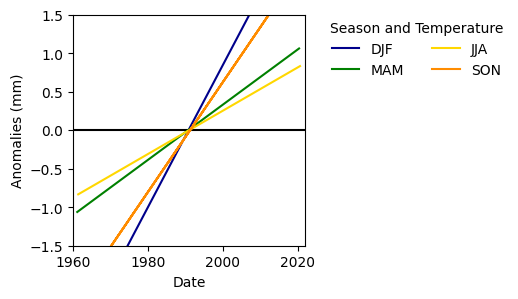

In [ ]:
# Input
datasets = ["prec"]  # Pick dataset
seasons_to_plot = ["DJF", "MAM", "JJA", "SON"]
iseed = 1  # Set seed


# Load data
df_list = []

for dataset in datasets:
    # Get file
    file = f"/Volumes/SAMSUNG 1TB/digitalis_v3/processed/1km/{source}/{dataset}.feather"
    # Load data
    idf = pd.read_feather(file)
    # Remove year 6120
    idf = idf.query("year != '6120'")
    # Fix temperature value
    idf["value"] = idf["value"] / 10
    # Take mean across all sites
    idf = idf.groupby(["year", "month"]).mean().reset_index()
    # Attach dataset info
    idf["tvar"] = dataset
    # Append to list
    df_list.append(idf)

# Concatenate
df = pd.concat(df_list)

# Attach month based on season
df["month"] = df["month"].astype(int)
df["season"] = df["month"].map(
    {
        1: "DJF",
        2: "DJF",
        3: "MAM",
        4: "MAM",
        5: "MAM",
        6: "JJA",
        7: "JJA",
        8: "JJA",
        9: "SON",
        10: "SON",
        11: "SON",
        12: "DJF",
    }
)

# Attach date
df["date"] = pd.to_datetime(
    df["year"].astype(str) + "-" + df["month"].astype(str) + "-01"
)
# Attach numeric date
df["date_num"] = mdates.date2num(df["date"])
display(df)

# Loop over every dataset and season, and calculate the anomalies trend for that season
df_lms = []
df_values = []

for tvar in datasets:
    for season in seasons_to_plot:
        # Filter for dataset and season
        idf = df.query(f"tvar == '{tvar}' & season == '{season}'").copy()
        # Calculate anomalies
        idf["value"] = idf["value"] - idf["value"].mean()
        # Regress anomalies on date_num
        lm = LinearRegression()
        lm.fit(idf[["date_num"]], idf["value"])
        df_lms.append(
            pd.DataFrame(
                {
                    "tvar": tvar,
                    "season": season,
                    "slope": lm.coef_[0],
                    "intercept": lm.intercept_,
                },
                index=[0],
            )
        )
        # Calculate the values for the regression line
        df_values.append(
            pd.DataFrame(
                {
                    "date_num": idf["date_num"],
                    "tvar": tvar,
                    "season": season,
                    "value": lm.predict(idf[["date_num"]]),
                }
            )
        )

df_lms = pd.concat(df_lms)
df_values = pd.concat(df_values)
df_values = df_values.replace({"tmoy": "Tmean", "tmax": "Tmax", "tmin": "Tmin"})
df_values

# Plot the regression lines, tvar is linetype, season is color shade
tvar_linetypes = {
    "Tmean": "-",
    "Tmax": "--",
    "Tmin": "-.",
}

season_colors = {
    "DJF": "darkblue",
    "MAM": "green",
    "JJA": "gold",
    "SON": "darkorange",
}

# Start plot
# fig, ax = plt.subplots(1, 1, figsize=(12, 3))
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

# Add zero line
ax.axhline(0, color="black", linestyle="-")

# Add lines
for tvar in df_values["tvar"].unique():
    for season in seasons_to_plot:
        idf = df_values.query(f"tvar == '{tvar}' & season == '{season}'")
        ax.plot(
            idf["date_num"],
            idf["value"],
            # linestyle=tvar_linetypes[tvar],
            color=season_colors[season],
        )

# Set the title and legend
# ax.set_title(
#     "Trends for different temperature variables and seasons", fontweight="bold"
# )
ax.set_xlabel("Date")
ax.set_ylabel("Anomalies (mm)")

# Use equal ylim
ax.set_ylim(-1.5, 1.5)

# Set x-axis to date format
ax.set_xlim(-3500.0, 19000)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_major_locator(mdates.YearLocator())

# Show every 10th date to avoid overlapping
ax.set_xticks(ax.get_xticks()[::20])

# Create legend handles for tvar linetypes
# tvar_handles = [
#     mlines.Line2D([], [], color="black", linestyle=linetype, label=tvar)
#     for tvar, linetype in tvar_linetypes.items()
# ]

# Create legend handles for season colors
season_handles = [
    mlines.Line2D([], [], color=color, linestyle="-", label=season)
    for season, color in season_colors.items()
]

# Combine both sets of handles
fig.legend(
    handles=season_handles,  # + tvar_handles,  # Combine both sets of handles
    loc="upper right",  # Position at the center top
    bbox_to_anchor=(1.6, 0.9),  # Move the legend below the plot
    # loc="upper left",  # Position at the center top
    # bbox_to_anchor=(0.125, 0.9),  # with upper left and fig size 6,3
    ncol=2,  # Arrange all items in one row
    title="Season",  # Title for the legend
    frameon=False,
)

# Show the plot (optional, as this is just for the legend)
# plt.tight_layout(rect=[0, 0, 0.4, 1])
plt.show()

## Climate Evolution Maps


In [4]:
import sys

sys.path.insert(0, "../../src")
from imports import *

init_notebook()

import rasterio
import numpy as np
import pandas as pd
from rasterio.transform import Affine

import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from scipy.stats import mode

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# Pick aggregation factor
agg_factor_km = 10
agg_factor_m = agg_factor_km * 1000
# Pick dataset
dataset = "tmoy"
# Pick time period
first_year = 1980
last_year = 2020
range_years = np.arange(first_year, last_year + 1)
# Pick season
season = "hi"  # pr, et, au, hi, 13

In [1]:
# Get files
files_all = glob.glob(f"/Volumes/SAMSUNG 1TB/digitalis_v3/raw/1km/{dataset}/*.tif")
files_all = pd.DataFrame(files_all, columns=["files"])
# Attach year
files_all["year"] = files_all["files"].apply(lambda x: x.split("/")[-1].split("_")[1])
files_all["year"] = files_all["year"].astype(int)
# Attach month
files_all["month"] = files_all["files"].apply(
    lambda x: x.split("/")[-1].split("_")[2].split(".")[0]
)
# Remove 6120 files
files_all = files_all.query("year != 6120")
# Sort by year and month
files_all = files_all.sort_values(by=["year", "month"]).reset_index(drop=True)

# Folder to save aggregated files (not really needed because quick enough)
agg_folder = f"/Volumes/SAMSUNG 1TB/digitalis_v3/processed/aggregated-to-{agg_factor_km}km/{dataset}"
os.makedirs(agg_folder, exist_ok=True)

# Attach csv filenames, make loop to make it easier
files_all["csv_files"] = ""

for i, row in files_all.iterrows():
    files_all.loc[i, "csv_files"] = f"{agg_folder}/{row.year}_{row.month}.csv"

# Filter for season
files = files_all.query(f"month == '{season}'").reset_index(drop=True)
# Filter for range of years
files = files.query("year >= @first_year & year <= @last_year").reset_index(drop=True)
# Display
files.head(5)

NameError: name 'glob' is not defined

In [31]:
dfs = []

for i in tqdm(range(len(files))):
    df = aggregate_raster_to_csv(
        input_raster_path=files.loc[i, "files"],
        output_csv_path=files.loc[i, "csv_files"],
        agg_factor_m=agg_factor_m,
        save_file=False,
    )

    # Get year from filename
    df["year"] = files.loc[i, "year"]
    df["month"] = files.loc[i, "month"]

    # Append to list
    dfs.append(df)

# Concatenate
df = pd.concat(dfs).reset_index(drop=True)

# Attach unique coordinates
df["xy"] = df["x"].astype(str) + "_" + df["y"].astype(str)

# Divide values by 10 to get correct value
df["value"] = df["value"] / 10
df

100%|██████████| 41/41 [00:01<00:00, 30.31it/s]


,x,y,value,year,month,xy
0,1.041127e+05,7.105530e+06,NaN,1980,hi,104112.68519994829_7105530.444145739
1,1.141127e+05,7.105530e+06,NaN,1980,hi,114112.68519994771_7105530.444145739
2,1.241127e+05,7.105530e+06,NaN,1980,hi,124112.68519994713_7105530.444145739
3,1.341127e+05,7.105530e+06,NaN,1980,hi,134112.68519994654_7105530.444145739
4,1.441127e+05,7.105530e+06,NaN,1980,hi,144112.68519994596_7105530.444145739
...,...,...,...,...,...,...
495439,1.194113e+06,6.055530e+06,NaN,2020,hi,1194112.6851998847_6055530.444145739
495440,1.204113e+06,6.055530e+06,NaN,2020,hi,1204112.6851998842_6055530.444145739
495441,1.214113e+06,6.055530e+06,NaN,2020,hi,1214112.6851998835_6055530.444145739
495442,1.224113e+06,6.055530e+06,NaN,2020,hi,1224112.685199883_6055530.444145739


In [16]:
# At resolution of 1km, it takes about 40 minutes
filename = (
    agg_folder
    + f"/trend_per_pixel-months_{season}-from_{first_year}_to_{last_year}.feather"
)
load_file = True

# Load if file exists
if os.path.exists(filename) and load_file:
    df_mp = pd.read_feather(filename)
    chime.info()
    print(f"File loaded from disk!: {filename}")
else:
    df_mp = get_trend_per_pixel_loop_mp(
        df.dropna(),
        group_var="xy",
        date_var="year",
        value_var="value",
    )
    chime.success()
    df_mp.to_feather(filename)
    print(f"File saved to disk!: {filename}")

 - Splitting df into 10 groups, grouped by xy


100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


File saved to disk!: /Volumes/SAMSUNG 1TB/digitalis_v3/processed/aggregated-to-10km/tmoy/trend_per_pixel-months_hi-from_1980_to_2020.feather


In [17]:
# df_mp was calculated with removing NA values, so we need to add these coordinates back
df_lm = pd.merge(df[["xy"]], df_mp, on="xy", how="left")
# Attach x and y
df_lm["x"] = df_lm["xy"].apply(lambda x: x.split("_")[0]).astype(float)
df_lm["y"] = df_lm["xy"].apply(lambda x: x.split("_")[1]).astype(float)
df_lm

,xy,value,x,y
0,104112.68519994829_7105530.444145739,NaN,1.041127e+05,7.105530e+06
1,114112.68519994771_7105530.444145739,NaN,1.141127e+05,7.105530e+06
2,124112.68519994713_7105530.444145739,NaN,1.241127e+05,7.105530e+06
3,134112.68519994654_7105530.444145739,NaN,1.341127e+05,7.105530e+06
4,144112.68519994596_7105530.444145739,NaN,1.441127e+05,7.105530e+06
...,...,...,...,...
495439,1194112.6851998847_6055530.444145739,NaN,1.194113e+06,6.055530e+06
495440,1204112.6851998842_6055530.444145739,NaN,1.204113e+06,6.055530e+06
495441,1214112.6851998835_6055530.444145739,NaN,1.214113e+06,6.055530e+06
495442,1224112.685199883_6055530.444145739,NaN,1.224113e+06,6.055530e+06


Saved fig to /Volumes/SAMSUNG 1TB/digitalis_v3/processed/aggregated-to-10km/tmoy/trend_per_pixel-months_hi-from_1980_to_2020.png


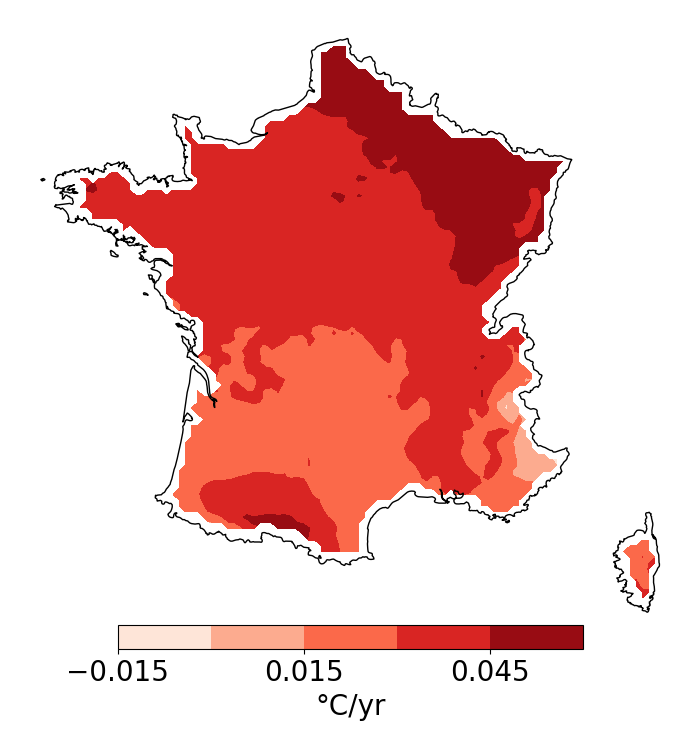

In [18]:
# the larger pixe_res, the longer it takes to calculate + the more granular the map becomes.
make_map_for_temp_prec_cover(
    df_lm,
    "tmoy",
    pixel_res=100j,
    textsize=20,
    contour_levels=5,
    filepath=filename.replace(".feather", ".png"),
)
chime.success()

### Single figures


In [5]:
import sys

sys.path.insert(0, "../../src")
from imports import *

init_notebook()

import rasterio
import numpy as np
import pandas as pd
from rasterio.transform import Affine

import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from scipy.stats import mode

from IPython.display import clear_output  # For clearing the output of a cell
import datetime as datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
dict_season = {
    "13": "Annual",
    "hi": "Winter",
    "pr": "Spring",
    "et": "Summer",
    "au": "Fall",
}

dict_dataset = {
    "tmoy": "Temperature",
    "prec": "Precipitation",
    "treecover": "Forest Cover",
}

In [16]:
pixel_res = 500j
agg_factor_km = 1

# for d in ["tmoy", "prec"]:
for d in ["prec"]:
    for s in ["13", "hi", "pr", "et", "au"]:
        for f in [1960, 1980, 2000]:
            display(f"Working on {d} for {s} over period {f} - 2020")
            print("... getting data")
            df_lm = produce_dfs_for_climate_evolution(
                agg_factor_km=agg_factor_km,
                dataset=d,
                first_year=f,
                last_year=2020,
                season=s,
                load_file=True,
            )

            print("... making map")
            make_map_for_temp_prec_cover(
                df_lm,
                d,
                pixel_res=pixel_res,
                textsize=20,
                contour_levels=7,
                filepath=f"/Volumes/SAMSUNG 1TB/digitalis_v3/processed/aggregated-to-{agg_factor_km}km/{d}/trend_per_pixel-months_{s}-from_{f}_to_{2020}-res_{pixel_res}.png",
            )
        clear_output()
        # display("Time: " + datetime.datetime.now().strftime("%H:%M:%S"))

'Working on prec for 13 over period 1960 - 2020'

... getting data
... making map
Saved fig to /Volumes/SAMSUNG 1TB/digitalis_v3/processed/aggregated-to-1km/prec/trend_per_pixel-months_13-from_1960_to_2020-res_500j.png


'Working on prec for 13 over period 1980 - 2020'

... getting data
... making map
Saved fig to /Volumes/SAMSUNG 1TB/digitalis_v3/processed/aggregated-to-1km/prec/trend_per_pixel-months_13-from_1980_to_2020-res_500j.png


'Working on prec for 13 over period 2000 - 2020'

... getting data
... making map
Saved fig to /Volumes/SAMSUNG 1TB/digitalis_v3/processed/aggregated-to-1km/prec/trend_per_pixel-months_13-from_2000_to_2020-res_500j.png


'Working on prec for hi over period 1960 - 2020'

... getting data
... making map
Saved fig to /Volumes/SAMSUNG 1TB/digitalis_v3/processed/aggregated-to-1km/prec/trend_per_pixel-months_hi-from_1960_to_2020-res_500j.png


'Working on prec for hi over period 1980 - 2020'

... getting data
... making map
Saved fig to /Volumes/SAMSUNG 1TB/digitalis_v3/processed/aggregated-to-1km/prec/trend_per_pixel-months_hi-from_1980_to_2020-res_500j.png


'Working on prec for hi over period 2000 - 2020'

... getting data
... making map
Saved fig to /Volumes/SAMSUNG 1TB/digitalis_v3/processed/aggregated-to-1km/prec/trend_per_pixel-months_hi-from_2000_to_2020-res_500j.png


'Working on prec for pr over period 1960 - 2020'

... getting data
... making map
Saved fig to /Volumes/SAMSUNG 1TB/digitalis_v3/processed/aggregated-to-1km/prec/trend_per_pixel-months_pr-from_1960_to_2020-res_500j.png


'Working on prec for pr over period 1980 - 2020'

... getting data
... making map
Saved fig to /Volumes/SAMSUNG 1TB/digitalis_v3/processed/aggregated-to-1km/prec/trend_per_pixel-months_pr-from_1980_to_2020-res_500j.png


'Working on prec for pr over period 2000 - 2020'

... getting data
... making map
Saved fig to /Volumes/SAMSUNG 1TB/digitalis_v3/processed/aggregated-to-1km/prec/trend_per_pixel-months_pr-from_2000_to_2020-res_500j.png


'Working on prec for et over period 1960 - 2020'

... getting data
... making map
Saved fig to /Volumes/SAMSUNG 1TB/digitalis_v3/processed/aggregated-to-1km/prec/trend_per_pixel-months_et-from_1960_to_2020-res_500j.png


'Working on prec for et over period 1980 - 2020'

... getting data
... making map
Saved fig to /Volumes/SAMSUNG 1TB/digitalis_v3/processed/aggregated-to-1km/prec/trend_per_pixel-months_et-from_1980_to_2020-res_500j.png


'Working on prec for et over period 2000 - 2020'

... getting data
... making map
Saved fig to /Volumes/SAMSUNG 1TB/digitalis_v3/processed/aggregated-to-1km/prec/trend_per_pixel-months_et-from_2000_to_2020-res_500j.png


'Working on prec for au over period 1960 - 2020'

... getting data
... making map
Saved fig to /Volumes/SAMSUNG 1TB/digitalis_v3/processed/aggregated-to-1km/prec/trend_per_pixel-months_au-from_1960_to_2020-res_500j.png


'Working on prec for au over period 1980 - 2020'

... getting data
... making map
Saved fig to /Volumes/SAMSUNG 1TB/digitalis_v3/processed/aggregated-to-1km/prec/trend_per_pixel-months_au-from_1980_to_2020-res_500j.png


'Working on prec for au over period 2000 - 2020'

... getting data
... making map
Saved fig to /Volumes/SAMSUNG 1TB/digitalis_v3/processed/aggregated-to-1km/prec/trend_per_pixel-months_au-from_2000_to_2020-res_500j.png


### Distribution Figures


In [7]:
# ! osascript -e 'tell app "System Events" to shut down'# Define parameters
seasons = ["13", "hi", "pr", "et", "au"]  # Columns
contour_levels = 11
last_year = 2020

for dataset in ["tmoy", "prec"]:

    # Create a figure and grid of axes
    fig, axs = plt.subplots(
        1,
        len(seasons),
        figsize=(18, 3),
    )
    axs = axs.flatten()

    # Iterate through the grid
    for i, season in enumerate(seasons):
        # Get the axis for the current grid cell
        ax = axs[i]

        # Plot the data
        df_1960 = produce_dfs_for_climate_evolution(
            agg_factor_km=1,
            dataset=dataset,
            first_year=1960,
            last_year=2020,
            season=season,
            load_file=True,
        )

        df_1980 = produce_dfs_for_climate_evolution(
            agg_factor_km=1,
            dataset=dataset,
            first_year=1980,
            last_year=2020,
            season=season,
            load_file=True,
        )

        df_2000 = produce_dfs_for_climate_evolution(
            agg_factor_km=1,
            dataset=dataset,
            first_year=2000,
            last_year=2020,
            season=season,
            load_file=True,
        )

        # Plot the histograms over each other
        df_1960.value.hist(
            bins=60,
            color="darkgreen",
            alpha=0.95,
            edgecolor="darkgreen",
            density=True,
            ax=ax,
        )
        df_1980.value.hist(
            bins=60,
            color="darkblue",
            alpha=0.95,
            edgecolor="darkblue",
            density=True,
            ax=ax,
        )
        df_2000.value.hist(
            bins=60,
            color="darkred",
            alpha=0.95,
            edgecolor="darkred",
            density=True,
            ax=ax,
        )
        plt.legend(["1960-2020", "1980-2020", "2000-2020"])
        if dataset == "tmoy":
            ax.set_xlabel("Temperature (°C/yr)")
        if dataset == "prec":
            ax.set_xlabel("Precipitation (mm/yr$^{-2}$)")

        ax.set_ylabel("Frequency")
        ax.set_title(f"{dict_season[season]}")

    plt.suptitle(f"Climate Evolution for {dict_dataset[dataset]}")
    plt.tight_layout()
    plt.savefig(
        f"../02_collect_features/climate_evolution_figures/histograms_for_{dataset}.png"
    )
    # plt.show()
    plt.close()

### Metric Grid - Period ~ Season


In [9]:
# Define parameters
first_years = [1960, 1980, 2000]  # Rows
seasons = ["13", "hi", "pr", "et", "au"]  # Columns
contour_levels = 11
last_year = 2020

for dataset in ["tmoy", "prec"]:

    # Create a figure and grid of axes
    fig, axs = plt.subplots(
        len(first_years),
        len(seasons),
        figsize=(15, 10),
    )

    # Iterate through the grid
    for row_idx, first_year in enumerate(first_years):
        for col_idx, season in enumerate(seasons):
            # Get the axis for the current grid cell
            ax = axs[row_idx, col_idx]

            # Generate the dataframe dynamically
            df_lm = produce_dfs_for_climate_evolution(
                agg_factor_km=1,
                dataset=dataset,
                first_year=first_year,
                last_year=last_year,
                season=season,
                load_file=True,
            )

            # Plot the map on the corresponding axis
            make_map_for_temp_prec_cover(
                df_lm,
                dataset,
                season,
                pixel_res=500j,
                textsize=10,
                contour_levels=contour_levels,
                cbar_pad=-0.02,
                cbar_fraction=0.2,
                cbar_shrink=0.6,
                cbar_aspect=20,
                tick_interval=2,
                ax=ax,  # Dynamically assign the axis
                filepath=f"/Volumes/SAMSUNG 1TB/digitalis_v3/processed/aggregated-to-{1}km/{dataset}/trend_per_pixel-months_{season}-from_{first_year}_to_{2020}-res_{500j}.png",
            )

            # Set the title for each subplot based on `first_year` and `season`
            ax.set_title(
                f"{dict_season[season]} ({first_year})",
                fontsize=12,
                fontweight="bold",
            )

    # Remove titles from all subplots
    for ax in axs.flatten():
        ax.set_title("")

    # Give the top row season names
    for i, season in enumerate(seasons):
        axs[0, i].set_title(f"{dict_season[season]}", fontsize=14, fontweight="bold")

    # Add y-axis by hand
    plt.text(
        0.1,
        0.23,
        "2000-2020",
        va="center",
        rotation="vertical",
        fontsize=14,
        fontweight="bold",
        transform=plt.gcf().transFigure,
    )
    plt.text(
        0.1,
        0.5,
        "1980-2020",
        va="center",
        rotation="vertical",
        fontsize=14,
        fontweight="bold",
        transform=plt.gcf().transFigure,
    )
    plt.text(
        0.1,
        0.72,
        "1960-2020",
        va="center",
        rotation="vertical",
        fontsize=14,
        fontweight="bold",
        transform=plt.gcf().transFigure,
    )

    plt.savefig(
        f"../02_collect_features/climate_evolution_figures/all_periods_for_{dataset}-{contour_levels}_contours.png",
        bbox_inches="tight",
    )
    # Display the figure
    # plt.show()
    plt.close()

### Period Grid - Metric ~ Season


In [11]:
# Inputs
agg_factor_km = 1
textsize = 15
pixel_res = 500j
# Local vars
dir_fig = "./climate_evolution_figures/"
os.makedirs(dir_fig, exist_ok=True)

season_dic = {
    "13": "Annual",
    "hi": "Winter",
    "pr": "Spring",
    "et": "Summer",
    "au": "Autumn",
}

datasets = [
    "tmoy",
    "tmoy",
    "tmoy",
    "tmoy",
    "tmoy",
    "prec",
    "prec",
    "prec",
    "prec",
    "prec",
]
seasons = ["13", "hi", "pr", "et", "au", "13", "hi", "pr", "et", "au"]

for f in [1960, 1980, 2000]:

    # Create 4x2 grid of plots
    fig, ax = plt.subplots(2, 5, figsize=(30, 15))
    ax = ax.flatten()

    for i, s in enumerate(seasons):
        df_lm = produce_dfs_for_climate_evolution(
            agg_factor_km=agg_factor_km,
            dataset=datasets[i],
            first_year=f,
            last_year=2020,
            season=s,
            load_file=True,
        )

        ax[i] = make_map_for_temp_prec_cover(
            df_lm,
            datasets[i],
            season=s,
            pixel_res=pixel_res,
            textsize=textsize,
            contour_levels=7,
            filepath=f"/Volumes/SAMSUNG 1TB/digitalis_v3/processed/aggregated-to-{agg_factor_km}km/{datasets[i]}/trend_per_pixel-months_{seasons[i]}-from_{f}_to_{2020}-res_{pixel_res}.png",
            ax=ax[i],
        )
        # Fix title
        ax[i].set_title(
            season_dic[s], loc="left", fontweight="bold", fontsize=20, pad=0
        )

    # Save figure
    plt.tight_layout()

    plt.savefig(
        f"../02_collect_features/climate_evolution_figures/climate_evolution-{f}_to_2020_agg-{agg_factor_km}km-res_{pixel_res}.png"
    )
    plt.close()

# EOS

---
